In [25]:
import pyfesom2 as pf
import matplotlib.cm as cm
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as nc
import argparse, os, sys

%matplotlib inline

In [10]:
######## Define #################
kwargs = {'use_cftime': 'True', 'naming_convention' : "custom", 'naming_template':"{}.{}.{}01.01.nc"}

# expname='tran-38pma1-v2-38k'
meshpath = '/home/a/a270075/ba0989/pool/meshes/base21k/mesh_ice38pma1_ocean21_shallowMed/'
datapath='/home/a/a270075/ba0989/awiesm2.5/experiments-3/21k/outdata/fesom/'

ystart = 2000
yend = 2101

whichlat=[26.5, 35, 40]

# print()

### set the mesh and data information
print("- the mesh information")
foutname = 'amoc_timeseries.nc'


###
choose_mask = "Atlantic_MOC"
'''
    masks:
    Ocean Basins:
        "Atlantic_Basin"
        "Pacific_Basin"
        "Indian_Basin"
        "Arctic_Basin"
        "Southern_Ocean_Basin"
        "Mediterranean_Basin"
        "Global Ocean"
        "Global Ocean 65N to 65S"
        "Global Ocean 15S to 15N"
    MOC Basins:
        "Atlantic_MOC"
        "IndoPacific_MOC"
        "Pacific_MOC"
        "Indian_MOC"
    Nino Regions:
        "Nino 3.4"
        "Nino 3"
        "Nino 4"
'''

- the mesh information


'\n    masks:\n    Ocean Basins:\n        "Atlantic_Basin"\n        "Pacific_Basin"\n        "Indian_Basin"\n        "Arctic_Basin"\n        "Southern_Ocean_Basin"\n        "Mediterranean_Basin"\n        "Global Ocean"\n        "Global Ocean 65N to 65S"\n        "Global Ocean 15S to 15N"\n    MOC Basins:\n        "Atlantic_MOC"\n        "IndoPacific_MOC"\n        "Pacific_MOC"\n        "Indian_MOC"\n    Nino Regions:\n        "Nino 3.4"\n        "Nino 3"\n        "Nino 4"\n'

/home/a/a270075/ba0989/pool/meshes/base21k/mesh_ice38pma1_ocean21_shallowMed/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /home/a/a270075/ba0989/pool/meshes/base21k/mesh_ice38pma1_ocean21_shallowMed/pickle_mesh_py3_fesom2
Depth is None, 3d field will be returned
Depth is None, 3d field will be returned
--> years, nodes, levels (101, 95239, 48)
Calculate MOC ...
    2000-12-31 23:30:00
    2001-12-31 23:30:00
    2002-12-31 23:30:00
    2003-12-31 23:30:00
    2004-12-31 23:30:00
    2005-12-31 23:30:00
    2006-12-31 23:30:00
    2007-12-31 23:30:00
    2008-12-31 23:30:00
    2009-12-31 23:30:00
    2010-12-31 23:30:00
    2011-12-31 23:30:00
    2012-12-31 23:30:00
    2013-12-31 23:30:00
    2014-12-31 23:30:00
    2015-12-31 23:30:00
    2016-12-31 23:30:00
    2017-12-31 23:30:00
    2018-12-31 23:30:00
    2019-12-31 23:30:00
    2020-12-31 23:30:00
    2021-12-31 23:30:00
    2022-12-31 23:30:00
    2023-12-31 23:3

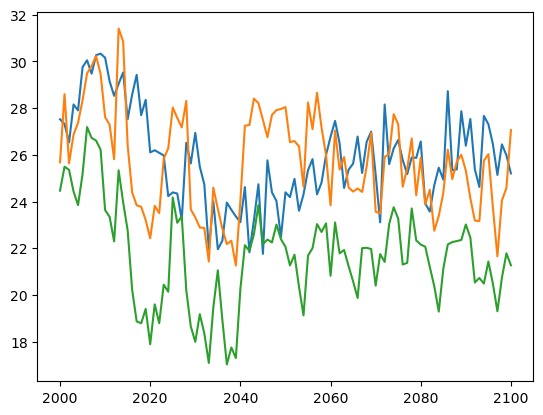

In [13]:
meshdir = meshpath
datadir = datapath

mesh = pf.load_mesh(meshdir)

# get data
data1 = pf.get_data(datadir, 'w', range(ystart,yend), mesh, how="ori", compute=False, **kwargs )
data2 = pf.get_data(datadir, 'bolus_w', range(ystart,yend), mesh, how="ori", compute=False , **kwargs)
print("--> years, nodes, levels", data1.shape)
data=data1+data2

# get mask
# mask1 = pf.get_mask(mesh, "Atlantic_Basin")
# mask2 = pf.get_mask(mesh, "Arctic_Basin")
# mask3 = mask1|mask2

years = range(ystart, yend)

# get moc
moc = []
print('Calculate MOC ...')
for i in range(data.shape[0]):
    print('   ', data.time[i].values)
    lats, moc_time = pf.xmoc_data(mesh, data[i,:,:], mask=choose_mask, nlats=361)
    moc.append(moc_time)

#########################
# write to file
#########################
fout = nc.Dataset(foutname, 'w',format='NETCDF4_CLASSIC')
fout.createDimension('time', None)
timeout = fout.createVariable('time',np.float32,('time',))
timeout.units = 'years since '+str(data.time[0].values)

timeout[:] = years  #np.arange(1,len(moc)+1)


# get index
for j in whichlat:
    indlat = np.where(lats == j)
    print('--> index_lat:', indlat[0] ,'lat:', lats[indlat[0]])
    moc_lat = []
    for i in range(len(moc)):
        moc_lat.append(moc[i][indlat,:].max())

    varname = 'AMOC_'+str(lats[indlat[0][0]])
    varout = fout.createVariable(varname,np.float32,('time',))
    varout[:] = moc_lat[:]

    plt.plot(years, moc_lat, label=j)
    

fout.close()


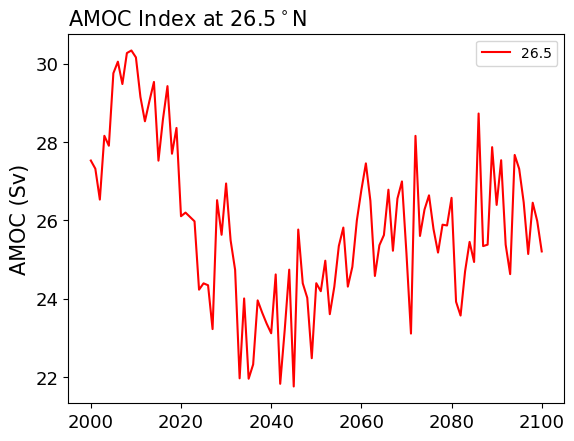

In [28]:
# plot
with nc.Dataset('amoc_timeseries.nc', 'r') as ff:
    amoc = ff.variables['AMOC_26.5'][:]

fig = plt.figure()
ax = fig.add_subplot(1, 1,1)

ax.plot(years, amoc, color='red', ls='-', label='26.5') 
# ax.set_xlim(1, 50)
# ax.set_ylim(0, 30)
ax.set_ylabel('AMOC (Sv)', fontsize=15)
ax.set_title('AMOC Index at 26.5$^\circ$N', fontsize=15,  loc='left')
ax.tick_params(labelsize=13)

ax.legend()

# plt.savefig(foutname.replace('.nc','.png'))
# plt.show(block=False)
# plt.pause(3)
# plt.close()